# Estimation of effective connectivity using MOU process (MOU-EC)

This Python notebook estimates a matrix of whole-brain effective connectivity (MOU-EC) for each fMRI session. The dataset comprises 22 subjects with 5 sessions each (2 for resting-state and 3 for movie, with distinct parts of the movie).

The goal is to fit a dynamic network model -the multivariate Ornstein-Uhlenbeck process, or MOU- to the empirical data. To do so, we tune the model parameter, in particular its connectivity MOU-EC, such that the model activity reproduces the BOLD covariances. Importantly, covariances are considered with time lags, meaning that the model aims to reproduce the statistics of the BOLD propagation between brain regions.

**References:**

- Appendix of Gilson et al. Biorxiv, http://doi.org/10.1101/531830
- Original version of the gradient descent: Gilson et al. PLoS Comput Biol (2016), http://doi.org/10.1371/journal.pcbi.1004762

In [1]:
## Import dependencies
import os
import numpy as np
import scipy.signal as spsg
import scipy.stats as stt
import matplotlib.pyplot as plt
%matplotlib inline

## Create a local folder to store results
res_dir = 'model_param_movie/'
if not os.path.exists(res_dir):
    print('created directory:',res_dir)
    os.makedirs(res_dir)

created directory: model_param_movie/


In [2]:
## Check whether pyMOU is installed, otherwise install using pip
try:
    import pymou
except:
    ! pip install git+https://github.com/mb-BCA/pyMOU.git@master

## Import pyMOU
from pymou.mou_model import MOU

  Cloning https://github.com/mb-BCA/pyMOU.git (to revision master) to /private/var/folders/n7/dqfcq8pj0g33r_vcx01n6jdm0000gn/T/pip-req-build-glg9h9wl
    100% |████████████████████████████████| 10.6MB 1.2MB/s ta 0:00:01    17% |█████▋                          | 1.9MB 8.9MB/s eta 0:00:01
    100% |████████████████████████████████| 296kB 2.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for pymou ... done
  Stored in directory: /private/var/folders/n7/dqfcq8pj0g33r_vcx01n6jdm0000gn/T/pip-ephem-wheel-cache-iyair8_1/wheels/a1/50/f3/8709c6b0583e30e92851727b5b0b56010ac3ebb6d24e394a64
Successfully built pymou


## Movie dataset

The data consist of 5 sessions for 22 subjects: 2 for rest (indexed by 0 and 1 in python) and 3 for movie viewing (2 to 4). Each session is 10-minute long and has 300 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to Hagmann et al. PLoS Biol 2008 with 66 regions of interest (ROIs).

The data files are:
- *ts_emp.npy*: BOLD time series (functional data)
- *SC_anat.npy*: anatomical connectome averaged over subjects (structural data)
- *ROI_labels.npy*: names of ROIs

We first filter the data in the broad frequency band [0.01,0.1] Hz, mainly to detrend the data due to very slow BOLD oscillations (with periods larger than 100 seconds).

shape of data array: (22, 5, 66, 300)


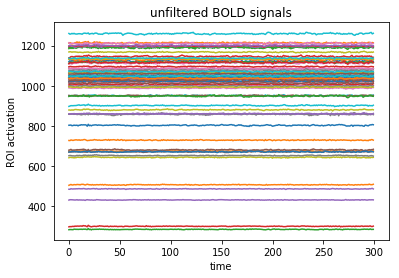

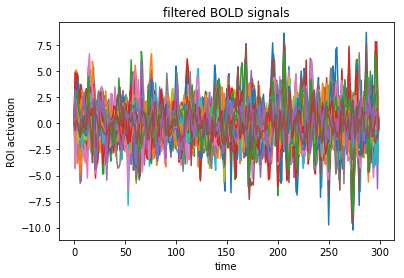

In [3]:
######################
# fMRI data properties    
n_sub = 22 # number of subjects
n_run = 5  # first 2 rest + last 3 movie
N = 66     # number of ROIs
T = 300    # number of TRs of the recording


#################
# Load the functional data
ts_emp = np.load('ts_emp.npy')
print('shape of data array:', ts_emp.shape)

# Time resolution for fMRI signals (in seconds)
TR = 2.0

# Filter the BOLD signals between 0.01 and 0.2 Hz
n_order = 3
Nyquist_freq = 0.5 / TR
low_f = 0.01 / Nyquist_freq
high_f = 0.2 / Nyquist_freq
b,a = spsg.iirfilter(n_order, [low_f,high_f], btype='bandpass', ftype='butter')

filtered_ts_emp = spsg.filtfilt(b,a,ts_emp, axis=-1)

# Visualise the BOLD signals
plt.figure()
plt.plot(range(T),ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('unfiltered BOLD signals')

plt.figure()
plt.plot(range(T),filtered_ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('filtered BOLD signals')

plt.show()

In [4]:
# Load the labels for brain regions (ROIs)
ROI_labels = np.load('ROI_labels.npy')
print('ROI list:\n', ROI_labels)


ROI list:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' '  lTT' '  lTP' 'lSMAR'
 '  lST' '  lSP' '  lSF' ' lRMF' ' lRAC' 'lPCUN' 'lPREC' '  lPC' 'lPSTC'
 'lPCAL' 'lPTRI' 'lPORB' 'lPOPE' 'lPARH' 'lPARC' '  lMT' ' lMOF' 'lLING'
 ' lLOF' 'lLOCC' 'lISTC' '  lIT' '  lIP' ' lFUS' '  lFP' ' lENT' ' lCUN'
 ' lCMF' ' lCAC' 'lBSTS']


## Functional connectivity

Functional connectivity is typically calculated using the Pearson correlation between BOLD time series, sometimes the mutual information. 

Here we use the BOLD covariances because they are natural objective functions for the MOU model, when tuning its parameters in order to fit data (in particular the directional connectivity). 

most of the FC values should be between 0 and 1
mean FC0 value: 0.12835421704567893
max FC0 value: 17.21125601909709
mean BOLD variance (diagonal of each FC0 matrix): 0.7383493119716743


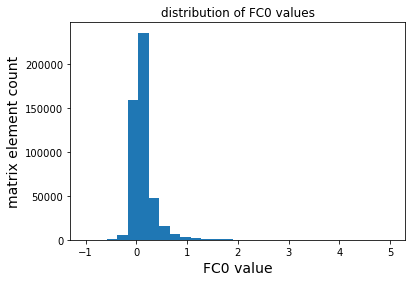

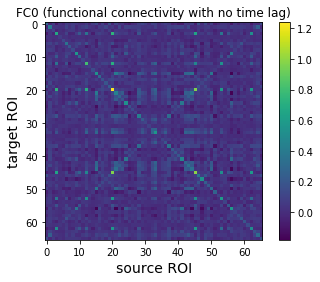

In [5]:
# Define the time shifts for FC: 0, 1 and 2 TR
v_tau = np.arange(3,dtype=float)
n_tau = v_tau.size

FC_emp = np.zeros([n_sub,n_run,n_tau,N,N]) # FC = spatiotemporal covariances of BOLD signals
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # center the time series
        filtered_ts_emp[i_sub,i_run,:,:] -= np.outer(filtered_ts_emp[i_sub,i_run,:,:].mean(1), np.ones([T]))
        # calculate covariances with time shift
        for i_tau in range(n_tau):
            FC_emp[i_sub,i_run,i_tau,:,:] = np.tensordot(filtered_ts_emp[i_sub,i_run,:,0:T-n_tau+1], filtered_ts_emp[i_sub,i_run,:,i_tau:T-n_tau+1+i_tau], axes=(1,1)) / float((T-n_tau))

rescale_FC_factor = 0.5 / FC_emp[:,:2,0,:,:].diagonal(axis1=2, axis2=3).mean()
FC_emp *= rescale_FC_factor
filtered_ts_emp /= np.sqrt(rescale_FC_factor)

print('most of the FC values should be between 0 and 1')
print('mean FC0 value:', FC_emp[:,:,0,:,:].mean())
print('max FC0 value:', FC_emp[:,:,0,:,:].max())
print('mean BOLD variance (diagonal of each FC0 matrix):', FC_emp[:,:,0,:,:].diagonal(axis1=2,axis2=3).mean())

# Show distibution of FC0 values
plt.figure()
plt.hist(FC_emp[:,:,0,:,:].flatten(), bins=np.linspace(-1,5,30))
plt.xlabel('FC0 value', fontsize=14)
plt.ylabel('matrix element count', fontsize=14)
plt.title('distribution of FC0 values')

# Show FC0 for first subject, first run (rest)
plt.figure()
plt.imshow(FC_emp[0,0,0,:,:])
plt.colorbar()
plt.xlabel('source ROI', fontsize=14)
plt.ylabel('target ROI', fontsize=14)
plt.title('FC0 (functional connectivity with no time lag)')

plt.show()

0-1 time lags
mean time constant rest: 1.5460220667078275
mean time constant movie: 1.6397069978017684
0-1-2 time lags
mean time constant rest: 0.6984301228994955
mean time constant movie: 0.8688797823079595


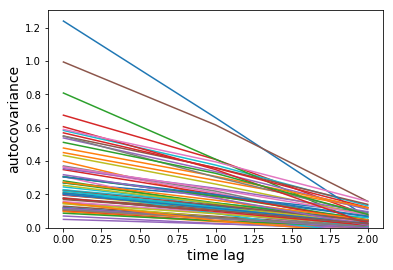

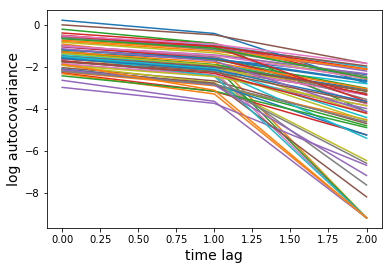

In [6]:
# Calculate the autocovariance
ac = FC_emp.diagonal(axis1=3,axis2=4)

print('0-1 time lags')
print('mean time constant rest:', 1. / ( np.log(ac[:,:2,0,:].mean()) - np.log(ac[:,:2,1,:].mean())) )
print('mean time constant movie:', 1. / ( np.log(ac[:,2:,0,:].mean()) - np.log(ac[:,2:,1,:].mean())) )

print('0-1-2 time lags')
print('mean time constant rest:', 2. / ( np.log(ac[:,:2,0,:].mean()) - np.log(ac[:,:2,2,:].mean())) )
print('mean time constant movie:', 2. / ( np.log(ac[:,2:,0,:].mean()) - np.log(ac[:,2:,2,:].mean())) )

plt.figure()
plt.plot(range(3), ac[0,0,:,:])
plt.axis(ymin=0)
plt.xlabel('time lag', fontsize=14)
plt.ylabel('autocovariance', fontsize=14)

plt.figure()
plt.plot(range(3), np.log(np.maximum(ac[0,0,:,:],1e-4)))
plt.xlabel('time lag', fontsize=14)
plt.ylabel('log autocovariance', fontsize=14)

plt.show()

## Structural connectivity for movie data

The structural data (e.g. diffusion tensor imaging, or DTI) typically indicate the probability or the density of white-mater projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized. To obtain this topological information, we threshold the values of the structural matrix that gives the mask of existing connections (boolean array). Typically, we use an average over many subjects and for parcellations with 100 ROIs the density of existing connections is around 30%.

An important point to check is that the order of the ROIs is the same for the functional and structural data, which is apparent here with the "antidiagonal" of the matrices that correspond to inter-hemispheric connections between homotopic ROIs (e.g. 0 = right BSTS and 65 = left BSTS).

EC density: 0.27505827505827507


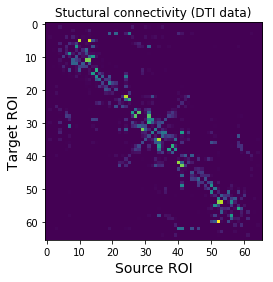

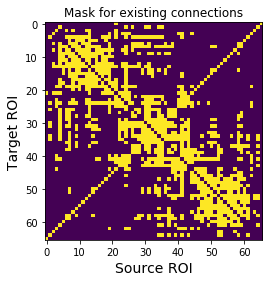

In [7]:
# Load the structural connectivity matrix
SC_anat = np.load('SC_anat.npy')

# Limit DTI value to determine SC (only connections with larger values are tuned)
lim_SC = 0.0 

# Set a mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC_anat > lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False    # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispheric connections
print('EC density:', mask_EC.sum() / float(N*(N-1)))

# Diagonal mask for input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N, dtype=bool)

# Visualise the structural connectivity and the mask
plt.figure()
plt.imshow(SC_anat)
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
plt.title('Stuctural connectivity (DTI data)', fontsize=12)

plt.figure()
plt.imshow(mask_EC)
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)

plt.show()

## MOU-EC estimation

The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the *MOU_Simulation_Estimation* notebook.

A few technical points:
- The current version of the gradient descent has slightly evolved since the original paper (Gilson et al. PLoS Comput Biol 2016, http://doi.org/10.1371/journal.pcbi.1004762), to refine the optimization of both connectivity matrix $C$ and input covariance matrix $\Sigma$. The current version is explained in the Appendix of Gilson et al. Biorxiv, http://doi.org/10.1101/531830.
- The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates. Try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.
- In addition to the topological constraint `mask_C`), it is possible to set a similar constraint on the input covariance (using `mask_Sigma`). Usually, we use a diagonal $\Sigma$, but see Gilson et al. Neuroimage 2018, http://doi.org/10.1016/j.neuroimage.2017.09.061 for considerations about inputs with cross-correlations.

In [8]:
# Run the model optimization 
# WARNING: Running this cell will take a few minutes
# Start initializing the target arrays
J_mod = np.zeros([n_sub,n_run,N,N])      # Jacobian (off-diagonal elements = EC)
Sigma_mod = np.zeros([n_sub,n_run,N,N])  # local variance (input covariance matrix, chosen to be diagonal)
dist_mod = np.zeros([n_sub,n_run])       # model error
R2_mod = np.zeros([n_sub,n_run])         # explained variance about the fitted data (FC covariance matrices)

mou_model = MOU()

for i_sub in range(n_sub):
    for i_run in range(n_run):
        # 1) Run the estimation of model parameters, for all sessions
        mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC,mask_Sigma=mask_Sigma) # , regul_C=0.5

        # 2) Organize the optimization results into arrays
        # Jacobian of the model
        J_mod[i_sub,i_run,:,:] = mou_model.J 
        # Noise (auto-)covariance matrix
        Sigma_mod[i_sub,i_run,:,:] = mou_model.Sigma
        # Matrix distance between the empirical objective covariances and their model counterparts 
        # (normalized for each objective matrix)
        dist_mod[i_sub,i_run] = mou_model.d_fit['distance'] 
        # The squared Pearson correlation is taken as an approximation of the variance explained R2 here
        R2_mod[i_sub,i_run] = mou_model.d_fit['correlation']**2 

        print('sub / run:',i_sub,i_run,';\t model error, R2:',dist_mod[i_sub,i_run], R2_mod[i_sub,i_run])

# Save the results into files
np.save(res_dir + 'FC_emp.npy', FC_emp)          # empirical spatiotemporal FC
np.save(res_dir + 'mask_EC.npy', mask_EC)        # mask of optimized connections
np.save(res_dir + 'mask_Sigma.npy', mask_Sigma)  # mask of optimized Sigma elements

np.save(res_dir + 'J_mod.npy', J_mod)            # estimated Jacobian matrices (EC + inverse time constant on diagonal)
np.save(res_dir + 'Sigma_mod.npy', Sigma_mod)    # estimated Sigma matrices
np.save(res_dir + 'dist_mod.npy', dist_mod)      # model error

print( '\nFinished.')

sub / run: 0 0 ;	 model error, R2: 0.7138181423505185 0.43325741060493617
sub / run: 0 1 ;	 model error, R2: 0.6449017576577125 0.4595015484085378
sub / run: 0 2 ;	 model error, R2: 0.6595816742377855 0.4065629287478669
sub / run: 0 3 ;	 model error, R2: 0.700086762107694 0.42815132373213827
sub / run: 0 4 ;	 model error, R2: 0.7135212539073847 0.3752531282369584
sub / run: 1 0 ;	 model error, R2: 0.6135388336934975 0.41441553033421064
sub / run: 1 1 ;	 model error, R2: 0.6176504452994381 0.50195887478444
sub / run: 1 2 ;	 model error, R2: 0.7141442595245469 0.38786533345249635
sub / run: 1 3 ;	 model error, R2: 0.6340864577379086 0.49133100056124074
sub / run: 1 4 ;	 model error, R2: 0.6809080166306937 0.42742241392834396
sub / run: 2 0 ;	 model error, R2: 0.5962438051799457 0.5084250725890896
sub / run: 2 1 ;	 model error, R2: 0.5791278402614712 0.49389096169247754
sub / run: 2 2 ;	 model error, R2: 0.7151140329133638 0.44782281237520544
sub / run: 2 3 ;	 model error, R2: 0.693995735

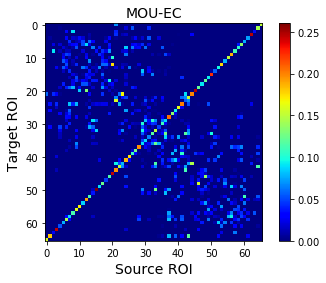

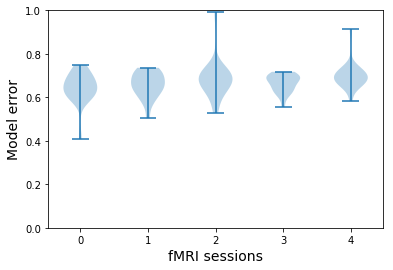

In [9]:
# Display an exmaple MOU-EC matrix and the model error for all runs and subjects
i_sub = 0
i_run = 0

plt.figure()
plt.imshow(J_mod[i_sub,i_run,:,:], vmin=0, cmap='jet')
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
plt.colorbar()
plt.title('MOU-EC', fontsize=14)

plt.figure()
plt.violinplot(dist_mod,positions=range(n_run))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions', fontsize=14)
plt.ylabel('Model error', fontsize=14)

plt.show()

Test difference asymmetry EC rest/movie: MannwhitneyuResult(statistic=934.0, pvalue=0.0007956843869031466)
Test difference asymmetry EC rest1/rest2: MannwhitneyuResult(statistic=207.0, pvalue=0.2090259542678003)


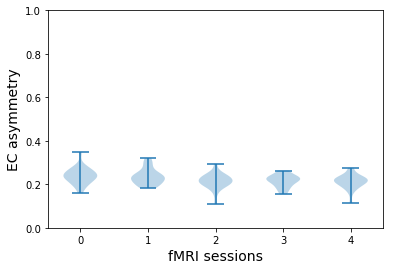

In [10]:
def asym(X):
    return np.abs(X-X.T).sum() / np.abs(X).sum() / 2

asym_EC = np.zeros([n_sub,n_run])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        C_tmp = J_mod[i_sub,i_run,:,:]
        C_tmp[np.eye(N,dtype=np.bool)] = 0
        asym_EC[i_sub,i_run] = asym(C_tmp)

print( 'Test difference asymmetry EC rest/movie:', stt.mannwhitneyu(asym_EC[:,:2].flatten(), asym_EC[:,2:].flatten()) )
print( 'Test difference asymmetry EC rest1/rest2:', stt.mannwhitneyu(asym_EC[:,0].flatten(), asym_EC[:,1].flatten()) )
        
plt.figure()
plt.violinplot(asym_EC,positions=range(n_run))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions', fontsize=14)
plt.ylabel('EC asymmetry', fontsize=14)

plt.show()

## Further exercises

- Compare EC between rest and movie using statistical testing (e.g. Welch t-test).
- Compare graph metrics on EC (as a directed weighted matrix) to corresponding graph metrics on SC, for example the node strength/degree to see how their hierarchy may differ (in particular between the two conditions, rest and movie).
- Compare EC with partial correlations PC.